# Algorithmic Fairness and Interpretability: Assignment
---
Goal of the notebook: Steps 1 to 10 of the assignment

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [70]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import os
import sys

%load_ext autoreload
%autoreload 2

# Change according to the path where the data is
os.chdir("D:/Algorithmic-Fairness-Interpretability/afi_final_project")
#os.chdir('C:/Users/dorab/OneDrive - Ecole Polytechnique/Documents/DSB - HECxX/Year 2/Algorithmic Fairness and Interpretability/afi_final_project')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 0: Exploratory Data Analysis

## 1. Load the data

In [4]:
df = pd.read_excel("data/dataproject2024.xlsx")

## 2. Overview

In [5]:
# Overview of the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    7430 non-null   int64  
 1   Job tenure            7430 non-null   int64  
 2   Age                   7430 non-null   int64  
 3   Car price             7430 non-null   int64  
 4   Funding amount        7430 non-null   int64  
 5   Down payment          7430 non-null   int64  
 6   Loan duration         7430 non-null   int64  
 7   Monthly payment       7430 non-null   float64
 8   Credit event          7430 non-null   int64  
 9   Married               7430 non-null   int64  
 10  Homeowner             7430 non-null   int64  
 11  Default (y)           7430 non-null   int64  
 12  Pred_default (y_hat)  7430 non-null   int64  
 13  PD                    7430 non-null   float64
 14  Group                 7430 non-null   int64  
dtypes: float64(2), int64(

In [6]:
num_features = [
    "Job tenure",
    "Age",
    "Car price",
    "Funding amount",
    "Loan duration",
    "Monthly payment",
]

cat_features = ["Down payment", "Credit event", "Married", "Homeowner"]

In [7]:
# Summary statistics of numerical columns
print(df.describe())

                ID   Job tenure          Age     Car price  Funding amount  \
count  7430.000000  7430.000000  7430.000000   7430.000000     7430.000000   
mean   3715.500000     9.329475    45.169717  12931.183311    11457.803769   
std    2145.000583     9.978638    14.790760   6202.407112     6015.033981   
min       1.000000     0.000000    18.000000    546.000000      546.000000   
25%    1858.250000     2.000000    33.000000   8147.750000     6845.250000   
50%    3715.500000     5.000000    46.000000  11950.000000    10382.500000   
75%    5572.750000    15.000000    55.000000  16500.000000    15000.000000   
max    7430.000000    58.000000    89.000000  47051.000000    30000.000000   

       Down payment  Loan duration  Monthly payment  Credit event  \
count   7430.000000    7430.000000      7430.000000   7430.000000   
mean       0.089367      56.220054         0.105143      0.022073   
std        0.285293      19.385787         0.061121      0.146930   
min        0.000000  

## 3. Distribution

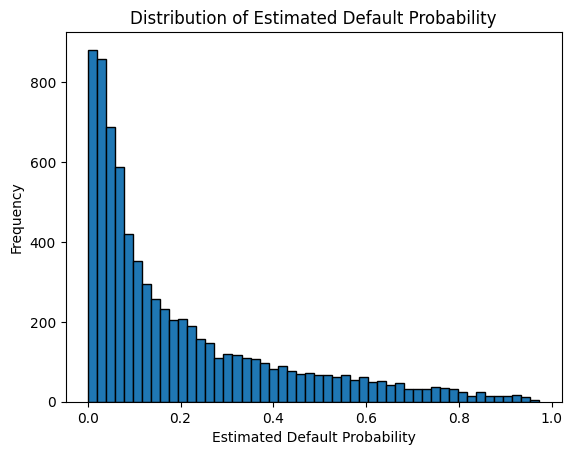

In [8]:
import matplotlib.pyplot as plt

# Histogram using matplotlib
plt.hist(df["PD"], bins=50, edgecolor="black")
plt.title("Distribution of Estimated Default Probability")
plt.xlabel("Estimated Default Probability")
plt.ylabel("Frequency")
plt.show()

Very skewed to the right.

## 4. Correlation

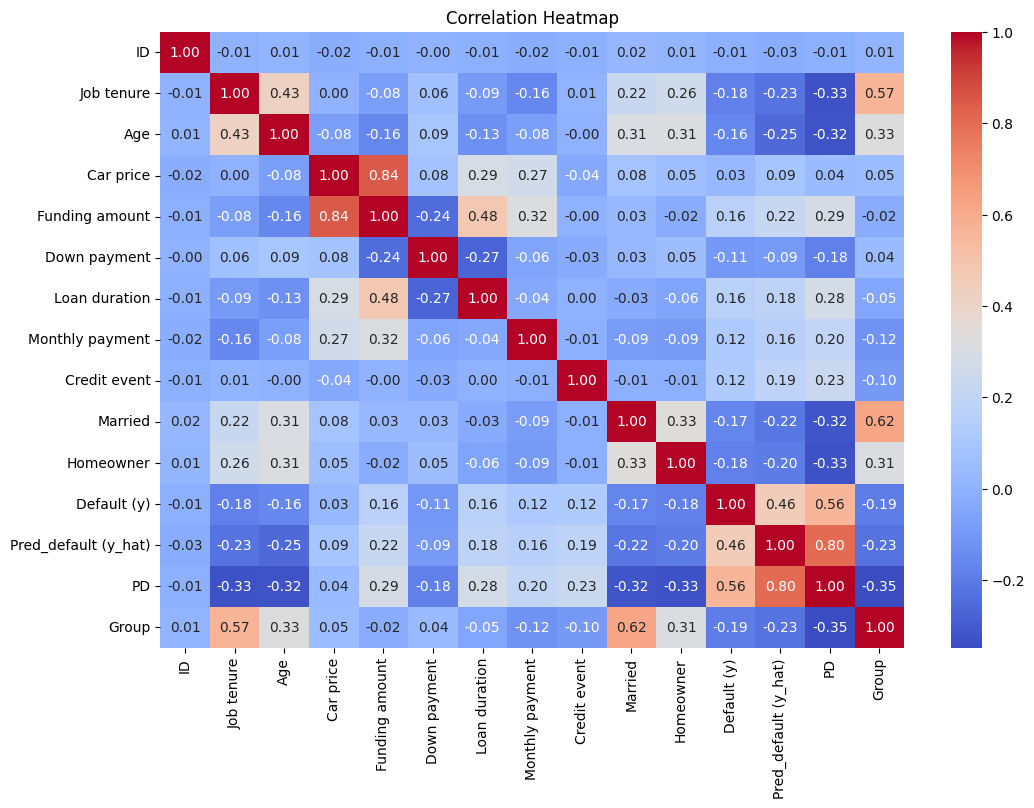

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Quite some correlated features:
- group + job tenure
- group + married
- homeowner + married
- loan duration + funding amount +  car price + monthly payment


We expect the features with the highest importance to be:
- job tenure
- age
- married
- homeowner
- group
- also loan duration and funding amount (but slightly less)

## 5. Multicollinearity

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = df.drop("PD", axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

print(vif_data)

                 feature        VIF
0                     ID   3.592593
1             Job tenure   3.406223
2                    Age  10.183947
3              Car price  27.902986
4         Funding amount  30.490185
5           Down payment   1.657359
6          Loan duration   9.725592
7        Monthly payment   4.299240
8           Credit event   1.095462
9                Married   4.080311
10             Homeowner   2.007662
11           Default (y)   1.645297
12  Pred_default (y_hat)   1.624522
13                 Group   3.546720


Quite a few features have very high VIF values (age, car price, funding amount, loan duration) indicating that there is multicollinearity between our features. This means that we should prefer tree-based algorithms to a linear regression or logistic regression. If we do linear regression we should consider applying a ridge regression or lasso to remove some correlated features.

## 6. Check for Non-Linearity

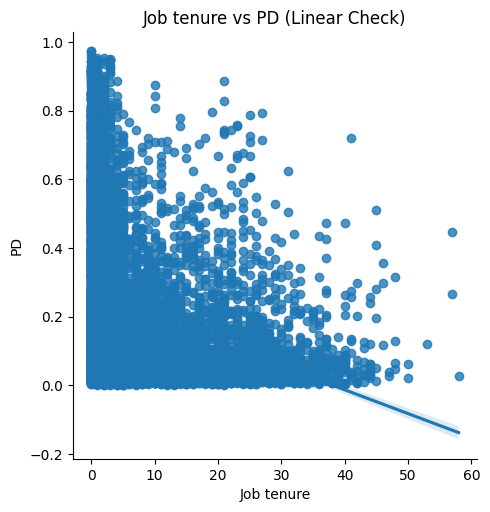

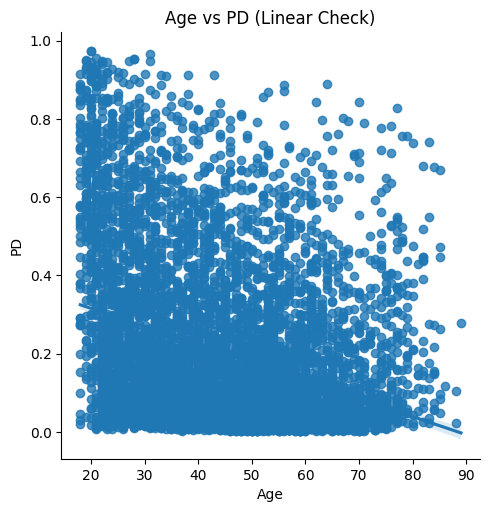

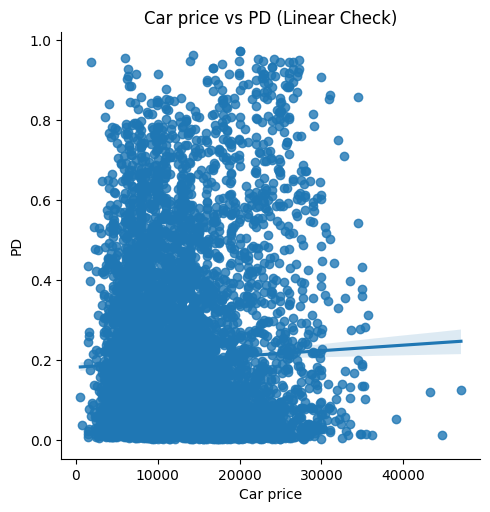

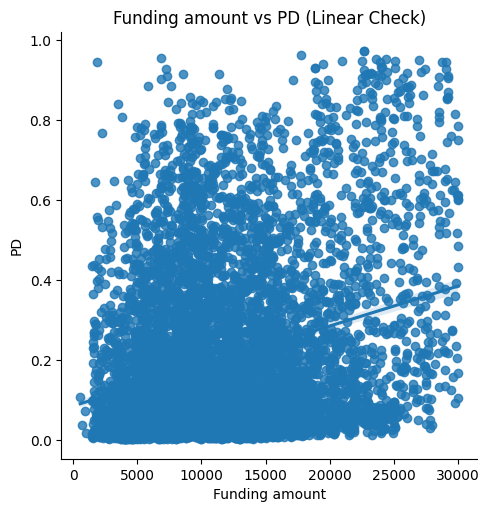

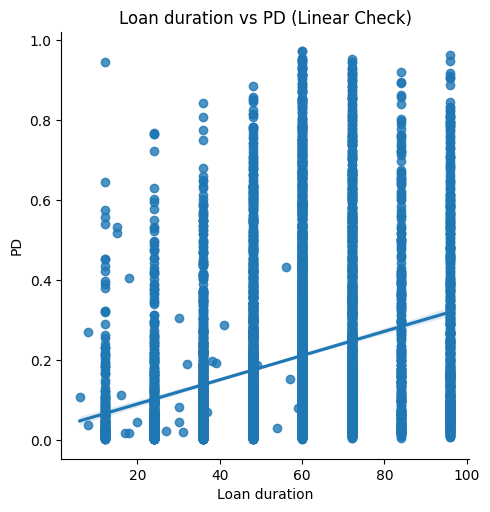

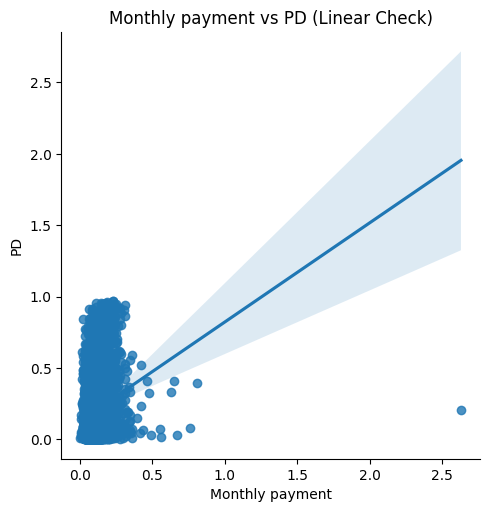

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for linear relationships with scatterplots for continuous variables
for col in num_features:
    if col != "target":  # Ensure you're not plotting the target against itself
        sns.lmplot(x=col, y="PD", data=df)
        plt.title(f"{col} vs PD (Linear Check)")
        plt.show()

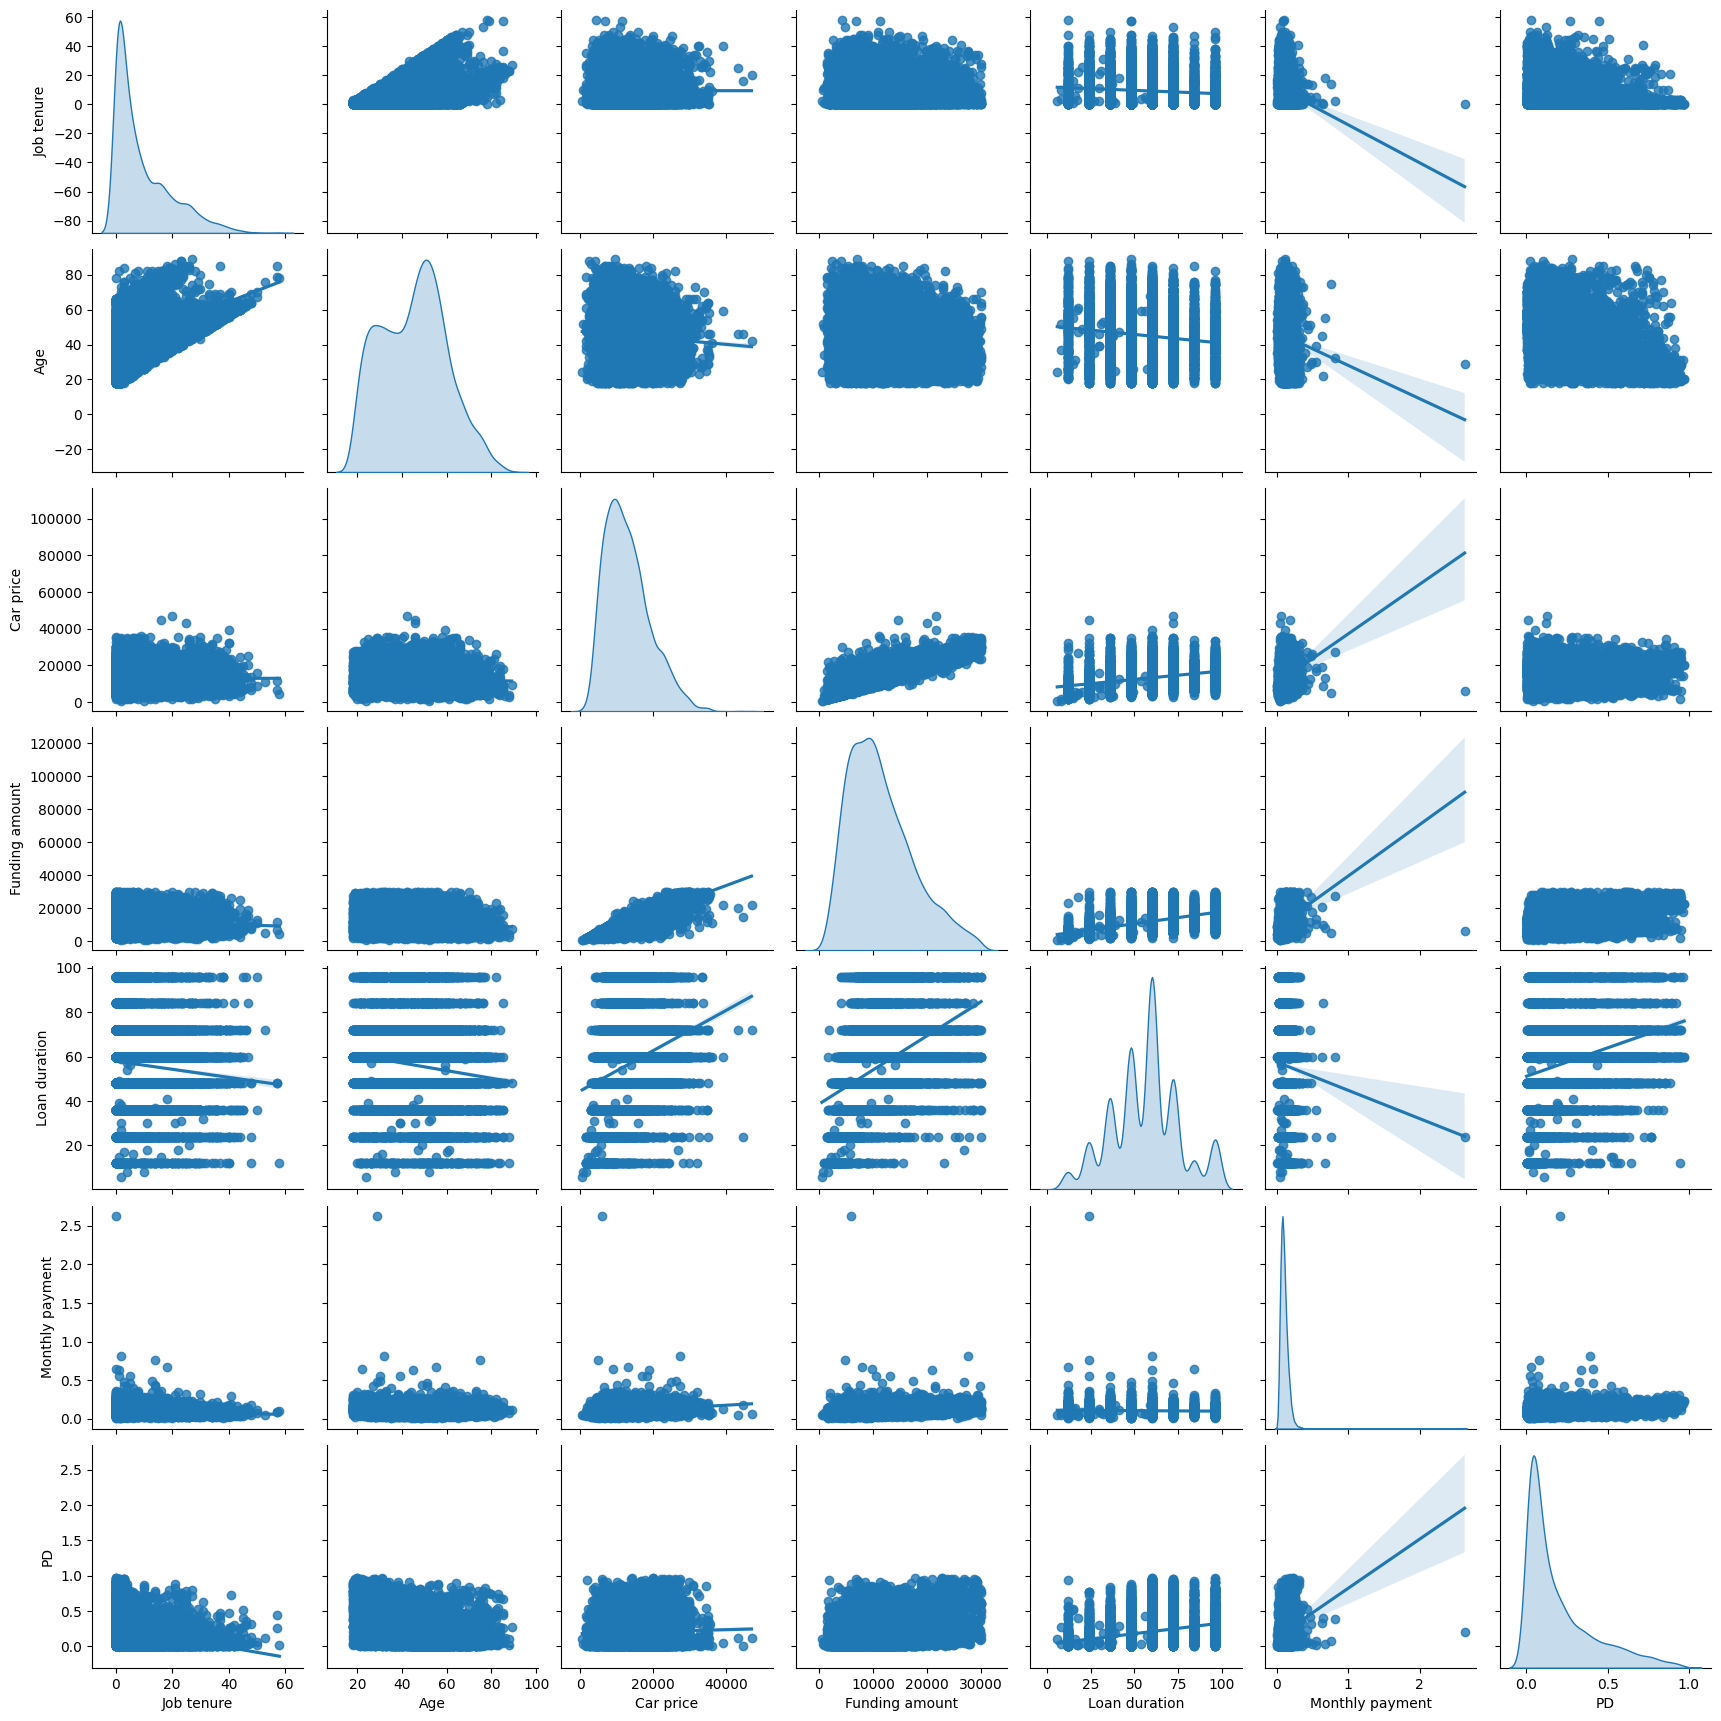

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 1. Filter the DataFrame to include only numerical features
df_num = df[num_features + ["PD"]]  # Add 'PD' to include the target for pairplot

# 2. Pairplot to detect non-linear relationships among numerical features
sns.pairplot(df_num, diag_kind="kde", kind="reg")  # kind="reg" adds regression line
plt.show()

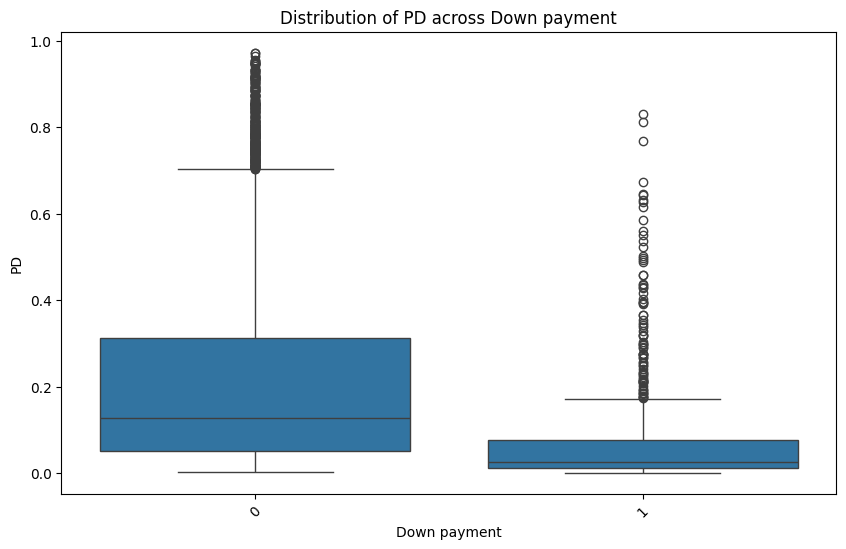

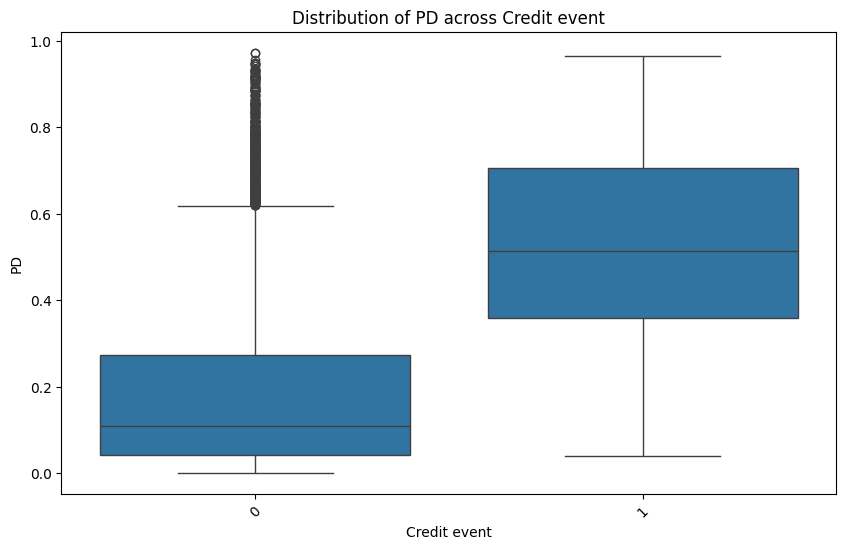

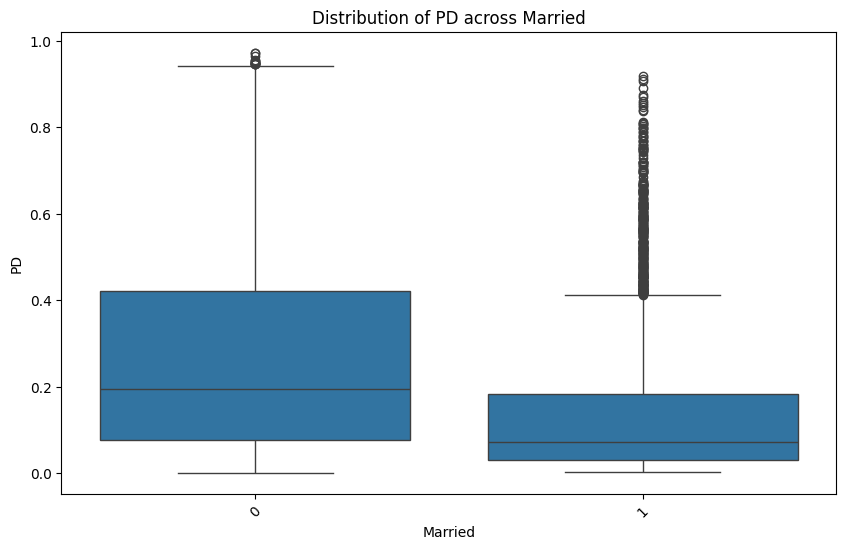

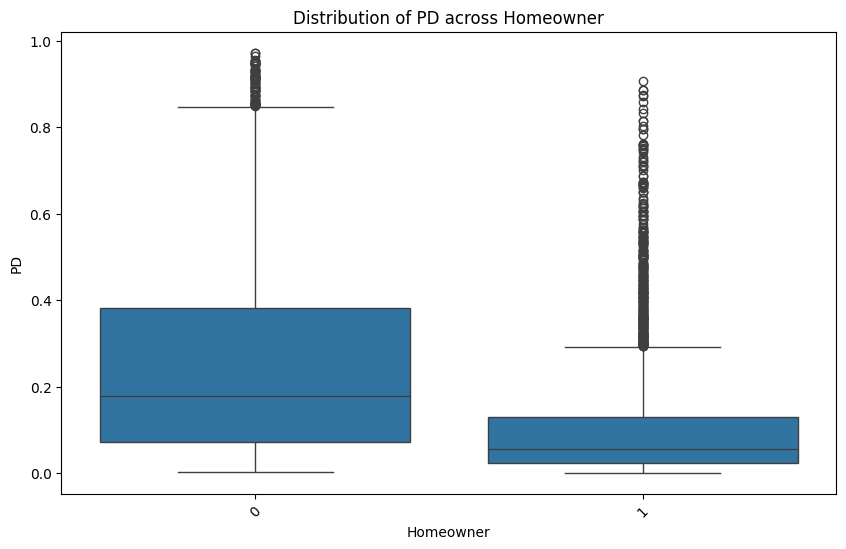

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each categorical feature and plot a boxplot for the target 'PD'
for feature in cat_features:
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    sns.boxplot(x=feature, y="PD", data=df)
    plt.title(f"Distribution of PD across {feature}")
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()

For many of the categorical features there are large jumps in median value and differences in spreads and interquartile range. This indicates there could be non linear relationships.

## 7. Check for Outliers

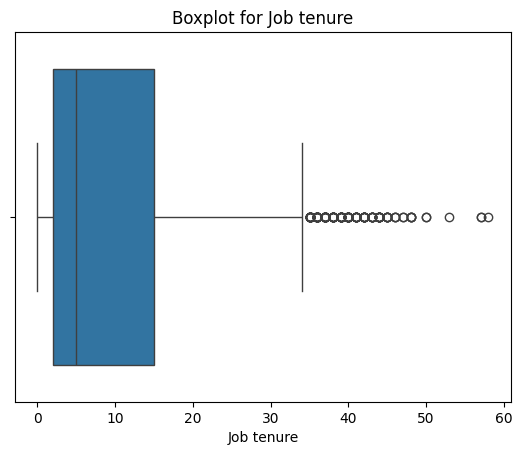

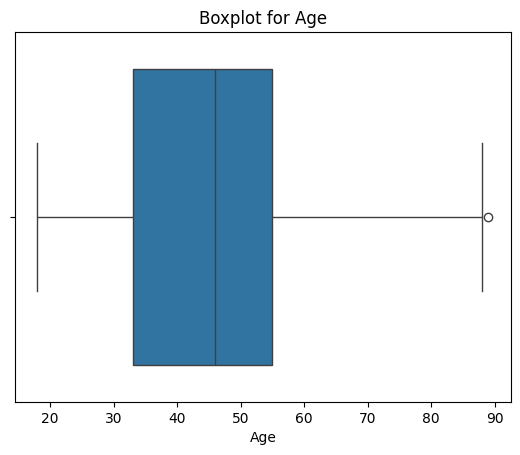

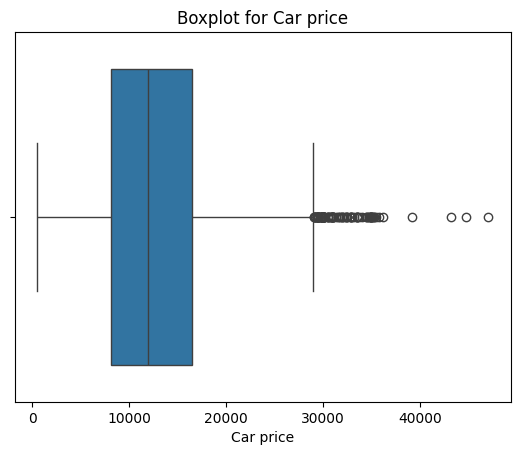

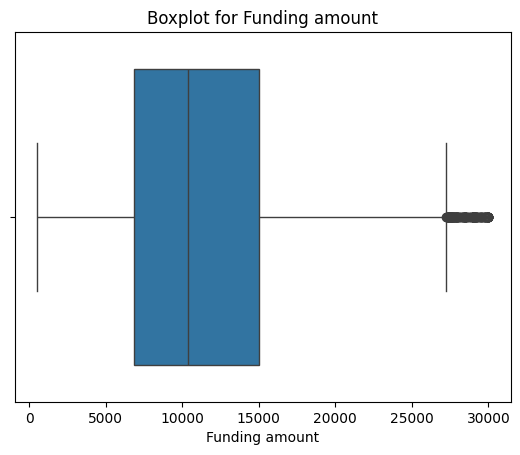

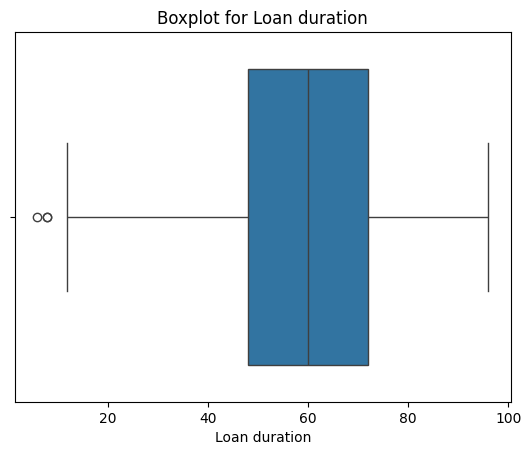

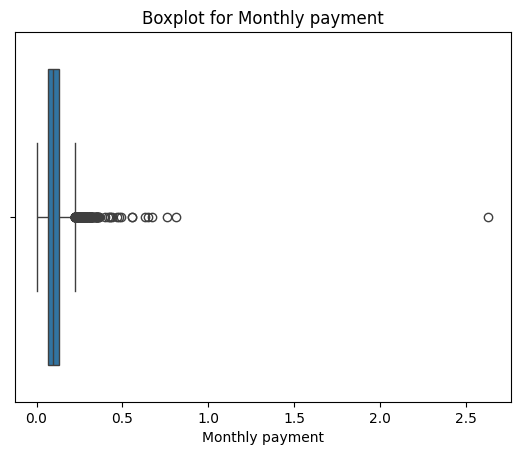

In [15]:
# Boxplot to detect outliers in continuous features
for col in num_features:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

There are some outliers. We should choose a model robust to this.

## 8. Check for Interactions

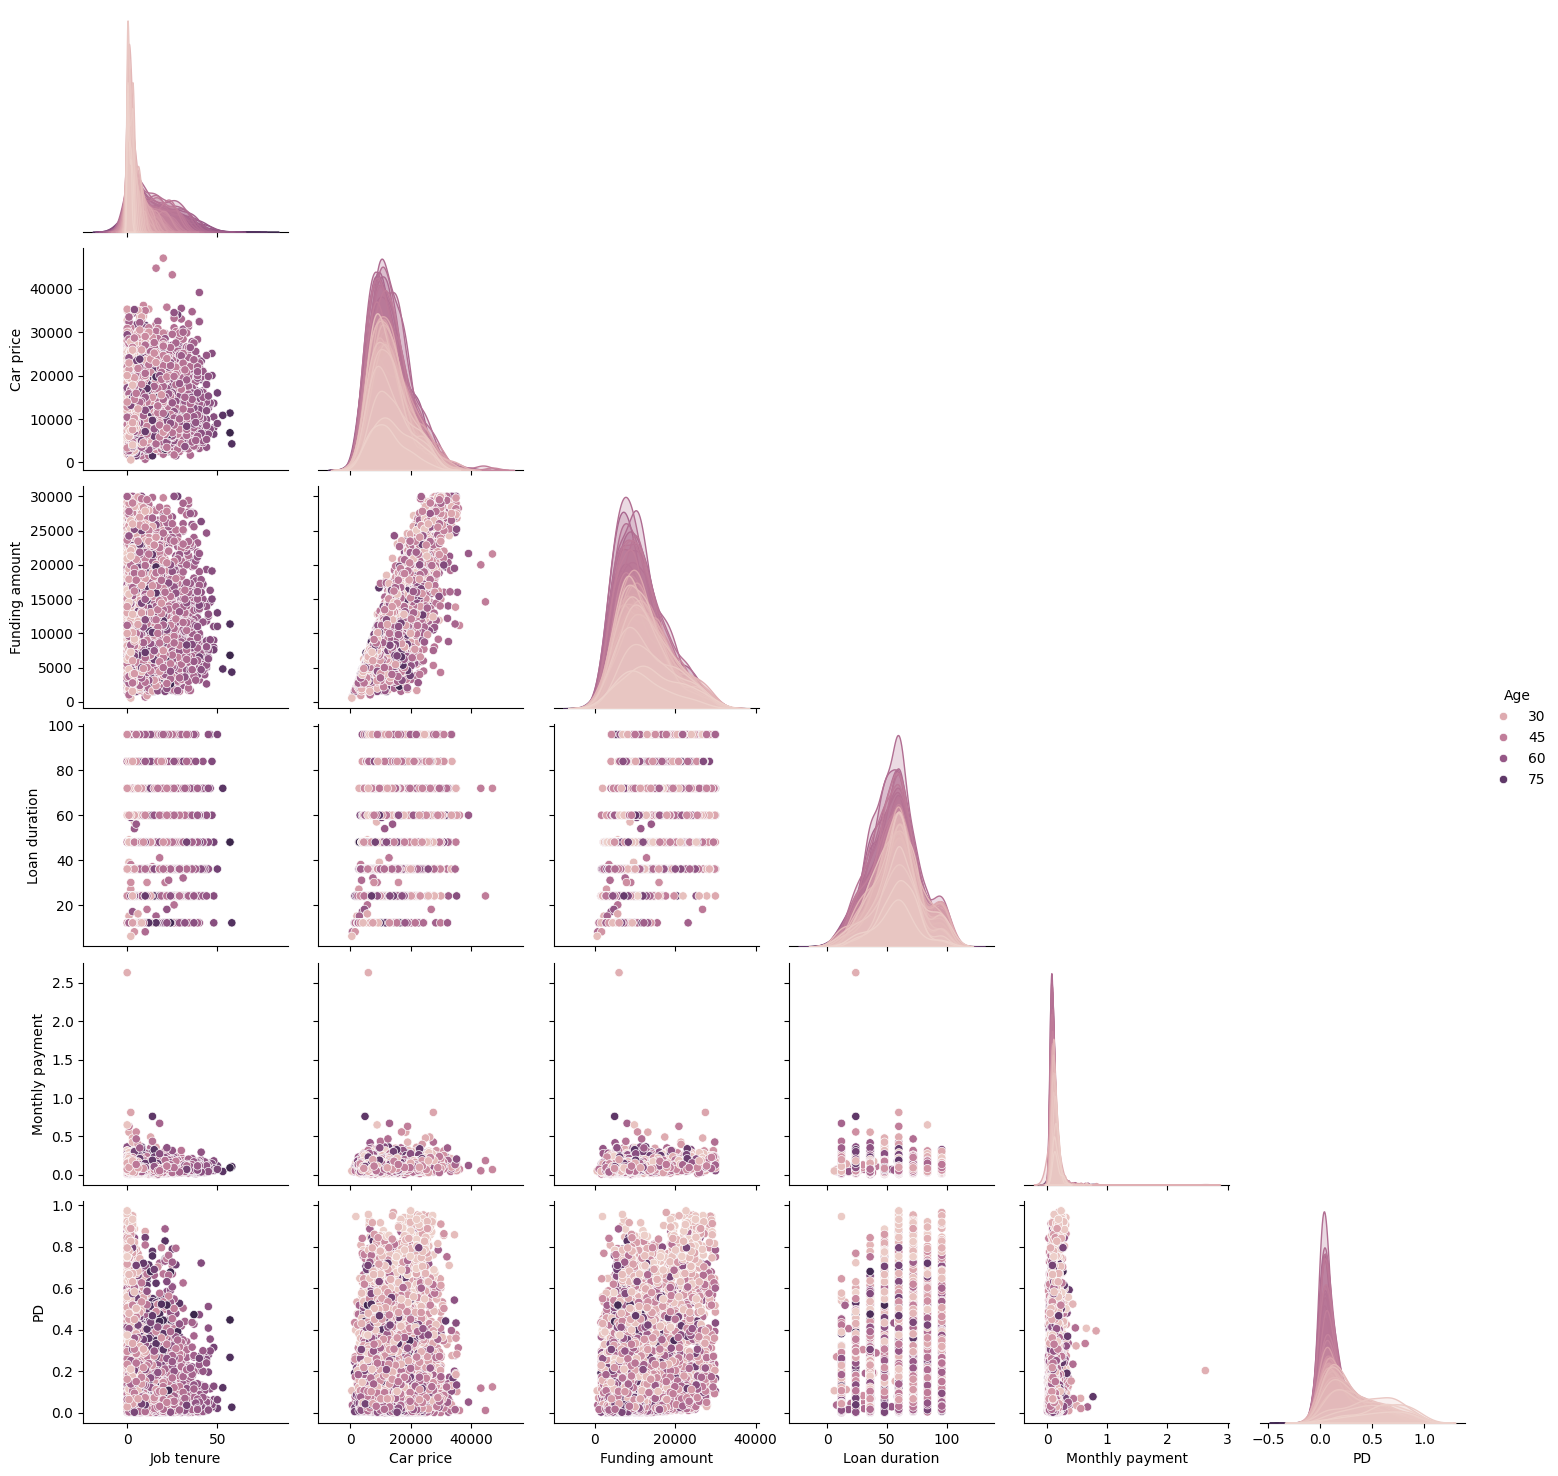

In [16]:
# Pairplot to detect potential interactions
sns.pairplot(df_num, hue="Age", corner=True)
plt.show()

There does seem to be interaction with age for several features like job tenure, car price, funding amount.

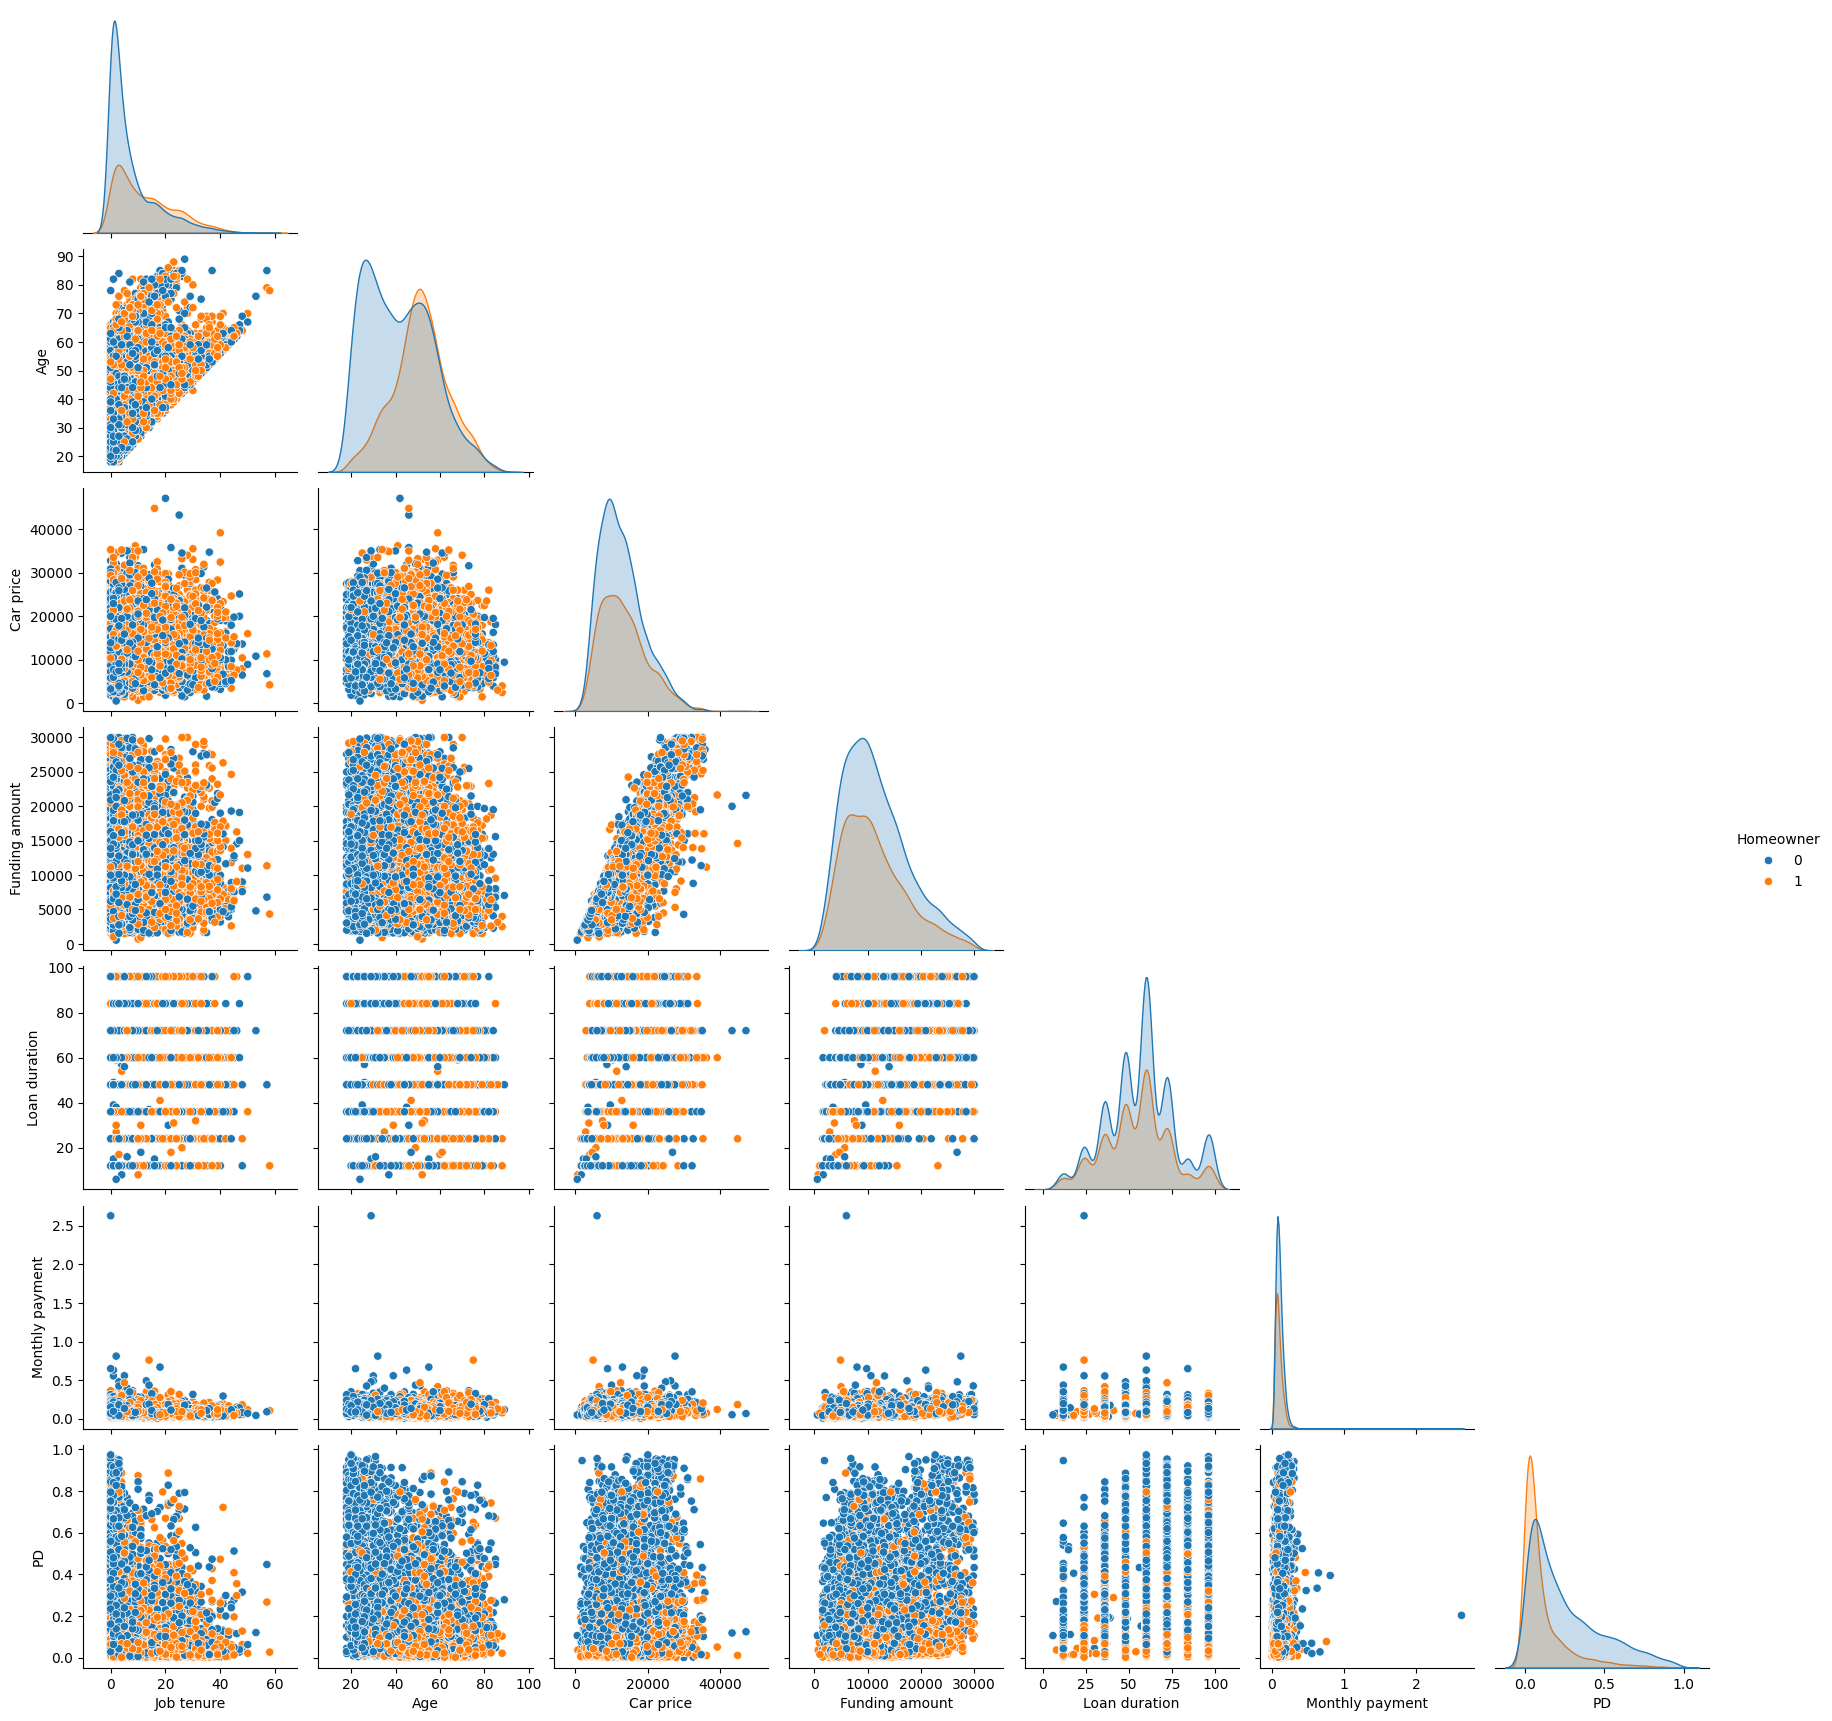

In [17]:
# Pairplot to detect potential interactions
sns.pairplot(df[list(df_num.columns) + ["Homeowner"]], hue="Homeowner", corner=True)
plt.show()

## 9. Check for class imbalance

In [18]:
# Get the ratio of classes
class_counts = df["Default (y)"].value_counts(normalize=True) * 100
print(f"Class balance:\n{class_counts}")

Class balance:
Default (y)
0    80.013459
1    19.986541
Name: proportion, dtype: float64


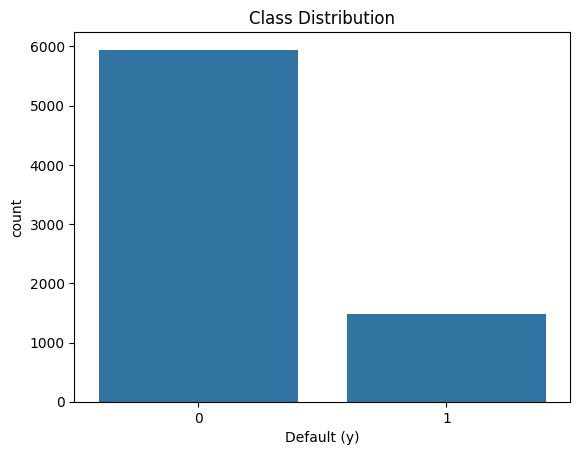

In [19]:
sns.countplot(x="Default (y)", data=df)
plt.title("Class Distribution")
plt.show()

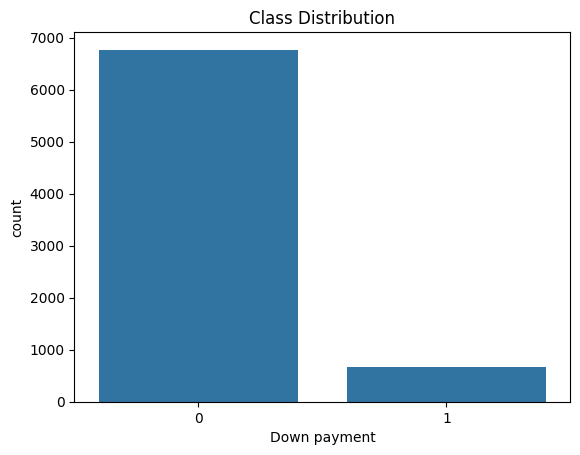

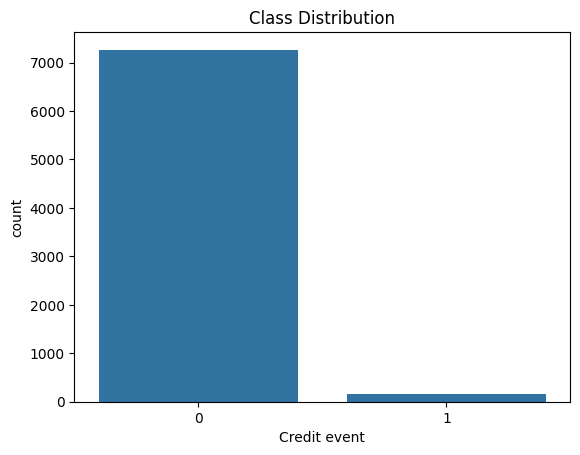

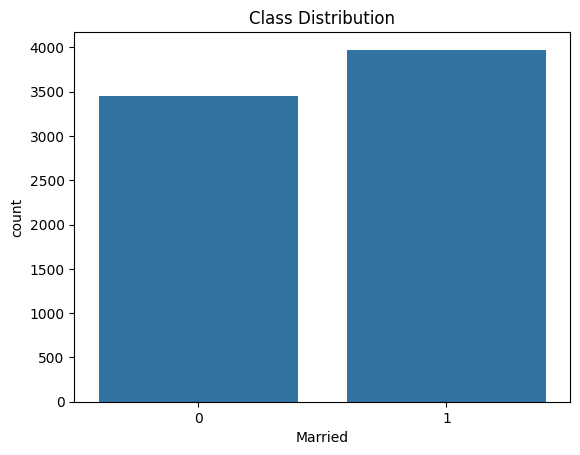

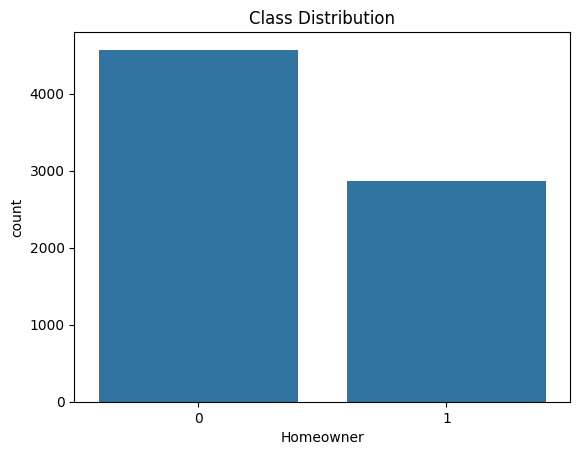

In [20]:
# Check for class imbalance
for feature in cat_features:
    sns.countplot(x=feature, data=df)
    plt.title("Class Distribution")
    plt.show()

# Step 1: Decision Tree Surrogate Model

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Defining features (X) and target (y)
X = df[
    [
        "Job tenure",
        "Age",
        "Car price",
        "Funding amount",
        "Down payment",
        "Loan duration",
        "Monthly payment",
        "Credit event",
        "Married",
        "Homeowner",
    ]
]
y = df["PD"]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Decision Tree model
tree = DecisionTreeRegressor(random_state=42, max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

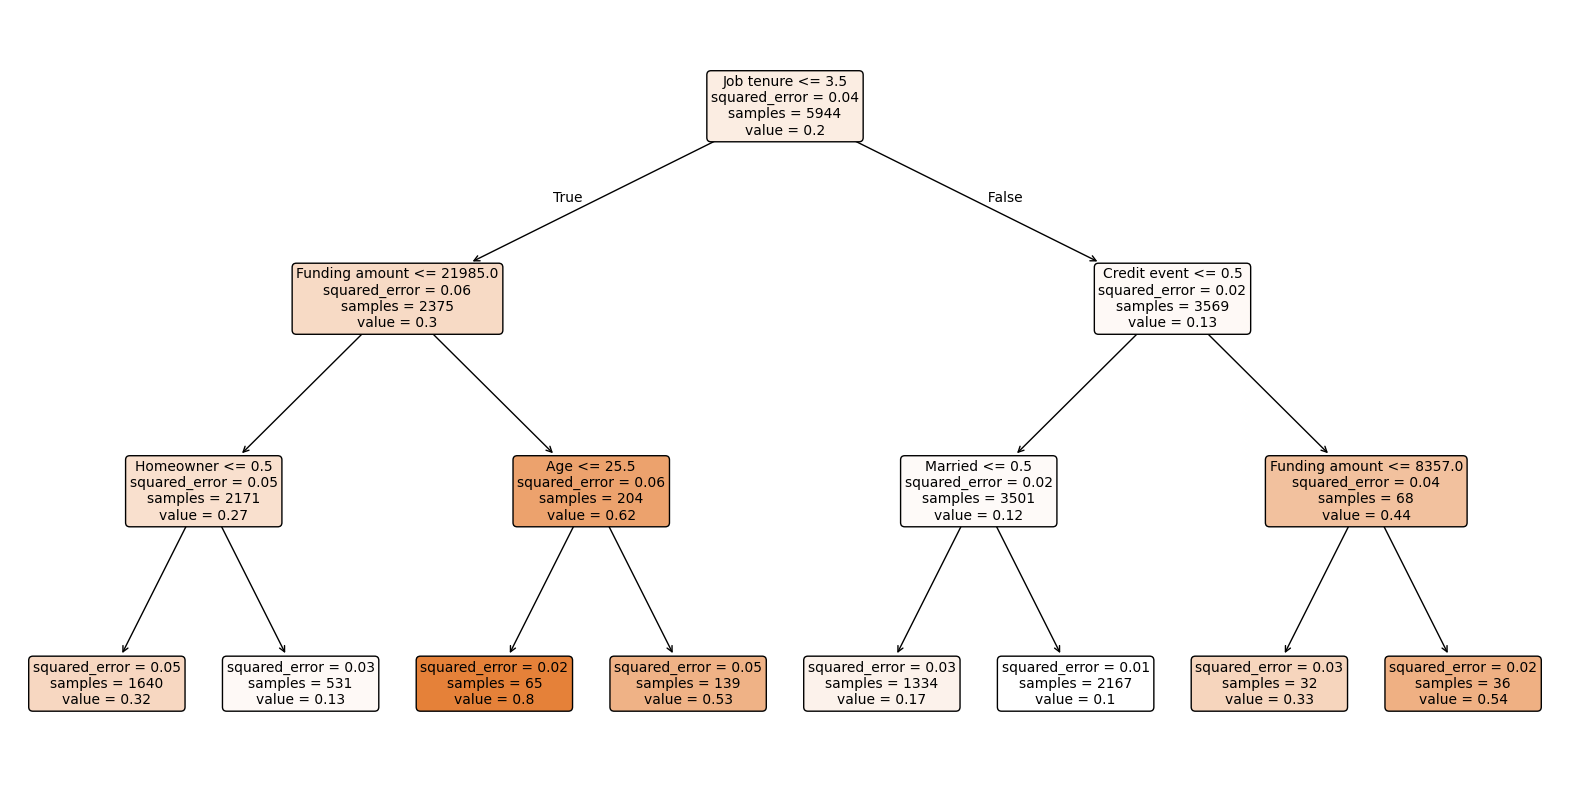

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plot_tree(
    tree,
    filled=True,
    feature_names=X.columns,
    rounded=True,
    precision=2,
    proportion=False,  # False means we will show the sample count, not proportion
    fontsize=10,  # Adjust font size for readability
    impurity=True,  # Show impurity (Gini or Entropy)
    class_names=True,
)

plt.show()

In [23]:
from sklearn.tree import export_text

tree_rules = export_text(tree, feature_names=list(X.columns))
print(tree_rules)

|--- Job tenure <= 3.50
|   |--- Funding amount <= 21985.00
|   |   |--- Homeowner <= 0.50
|   |   |   |--- value: [0.32]
|   |   |--- Homeowner >  0.50
|   |   |   |--- value: [0.13]
|   |--- Funding amount >  21985.00
|   |   |--- Age <= 25.50
|   |   |   |--- value: [0.80]
|   |   |--- Age >  25.50
|   |   |   |--- value: [0.53]
|--- Job tenure >  3.50
|   |--- Credit event <= 0.50
|   |   |--- Married <= 0.50
|   |   |   |--- value: [0.17]
|   |   |--- Married >  0.50
|   |   |   |--- value: [0.10]
|   |--- Credit event >  0.50
|   |   |--- Funding amount <= 8357.00
|   |   |   |--- value: [0.33]
|   |   |--- Funding amount >  8357.00
|   |   |   |--- value: [0.54]



In [24]:
# Predicting on the test set for both models
y_pred_tree = tree.predict(X_test)

Decision Tree - MSE: 0.030299016578028446, MAE: 0.12876413429915398, R²: 0.30911991669819894
Feature Importance from Decision Tree: [0.45362081 0.0355337  0.         0.24319809 0.         0.
 0.         0.07258665 0.04343492 0.15162584]


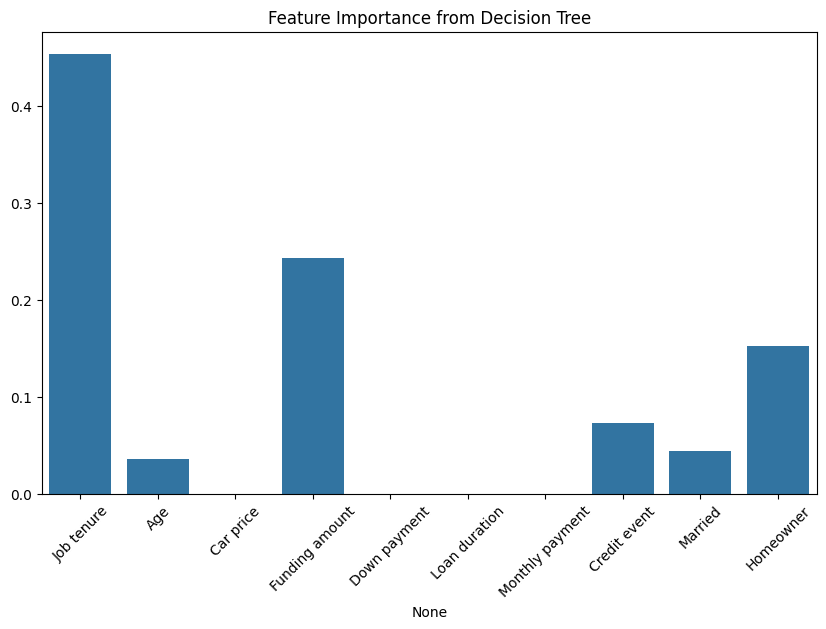

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Checking feature importance for Decision Tree
tree_feature_importance = tree.feature_importances_

print(f"Decision Tree - MSE: {mse_tree}, MAE: {mae_tree}, R²: {r2_tree}")
print("Feature Importance from Decision Tree:", tree_feature_importance)

# Visualization of Decision Tree feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y=tree_feature_importance)
plt.title("Feature Importance from Decision Tree")
plt.xticks(rotation=45)
plt.show()

- MSE: The MSE is 0.02379, which indicates how well the surrogate model approximates the unknown model's output. The lower the MSE, the better the approximation. Here it is quite low, so the model seems to fit the data well.

- Feature Importance: The feature importance from the surrogate model shows which features are driving the predictions of the unknown model. From the provided bar chart, it can be sees that:
    - Funding amount and Job tenure have the highest importance, which suggests that these features have a significant influence on the PD.
    - Age and Car price are also important features but to a lesser extent.
    - Features like Loan duration, Monthly payment, and Homeowner contribute moderately to the model.

We get very different results in terms of feature importance between the decision tree surrogate model and the linear regression surrogate model. This is to be expected as they are 2 models which work very differently. Most importantly, the linear regression surrogate model does not take into account non-linear relationships between the features in the target variable. Given our EDA we find non-linear relationships in our data and thus trust the decision tree surrogate model more.


Comparing the metrics of the 2 surrogate models we notice that the decision tree always gives better results, further confirming our conclusion.

# Step 1: Linear Regression Surrogate Model

In [28]:
X = df[
    [
        "Job tenure",
        "Age",
        "Car price",
        "Funding amount",
        "Down payment",
        "Loan duration",
        "Monthly payment",
        "Credit event",
        "Married",
        "Homeowner",
    ]
]
y = df["PD"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred_linear = linear_model.predict(X_test)

In [32]:
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

In [33]:
print("Mean Squared Error for Linear Regression:", mse_linear)
print("Mean Absolute Error for Linear Regression:", mae_linear)
print("Root Mean Squared Error for Linear Regression:", r2_linear)
print("Coefficients from Linear Regression:", linear_model.coef_)

Mean Squared Error for Linear Regression: 0.025293393693871583
Mean Absolute Error for Linear Regression: 0.12064726405671973
Root Mean Squared Error for Linear Regression: 0.42325844480117025
Coefficients from Linear Regression: [-2.95270984e-03 -1.26946613e-03 -2.12345492e-05  2.59022962e-05
  8.19682674e-02  1.14162934e-03  2.91973922e-01  3.15470946e-01
 -7.28916966e-02 -6.47144847e-02]


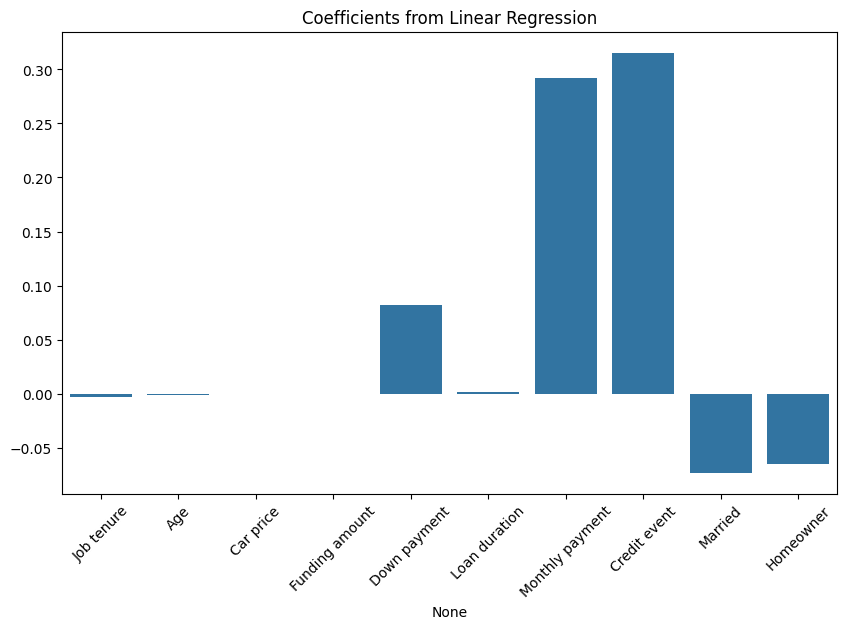

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y=linear_model.coef_)
plt.title("Coefficients from Linear Regression")
plt.xticks(rotation=45)
plt.show()

- A feature with a positive coefficient has a direct relationship with the target (PD). This means that as the value of this feature increases, the predicted PD increases.
- A feature with a negative coefficient has an inverse relationship with the target. This means that as the feature increases, the predicted PD decreases.

### Key observations:

- **Monthly payment** and **Credit event** have the largest positive coefficients:
These two features have the most substantial positive impact on the probability of default. As these values increase, the probability of default increases significantly.

- **Married** and **Homeowner** have negative coefficients:
Being married or a homeowner reduces the predicted probability of default, as indicated by the negative coefficients.

- **Down payment** has positive coefficients:
These features also increase the probability of default, though their influence is smaller compared to "Monthly payment" and "Credit event."

- **Job tenure**, **Loan duration**, and **Age** have near-zero coefficients:
These features have very little or no effect on the predicted probability of default. This suggests that, according to the linear regression model, variations in these features do not significantly influence the likelihood of default.

### Interpretation:
- **Credit event**: The most important feature. If the person had past credit events (like defaults or bankruptcies), it strongly increases the likelihood of default.
- **Monthly payment**: The second most important feature in predicting default probability. Higher monthly payments likely indicate more financial strain, increasing the risk of default.
- **Married and Homeowner**: These characteristics reduce the likelihood of default, potentially because they signify more financial stability.
- **Job tenure and Age**: These features don't seem to have a significant impact on the prediction of default probability in this model, meaning the model doesn't find these factors important in predicting PD.

Overall, the plot reveals which features the model considers most relevant in predicting the probability of default (PD). The highest positive bars indicate features that increase the risk of default, while negative bars (such as "Married" and "Homeowner") show features that decrease the risk.

# Step 1: Logistic Regression

In [51]:
X = df[
    [
        "Job tenure",
        "Age",
        "Car price",
        "Funding amount",
        "Down payment",
        "Loan duration",
        "Monthly payment",
        "Credit event",
        "Married",
        "Homeowner",
    ]
]
y = df["Pred_default (y_hat)"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [53]:
logistic_model = make_pipeline(
    StandardScaler(), LogisticRegression(solver="lbfgs", max_iter=200)
)
logistic_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [54]:
y_pred_log = logistic_model.predict(X_test)
y_pred_proba_log = logistic_model.predict_proba(X_test)[:, 1]

In [55]:
mse_logistic = mean_squared_error(y_test, y_pred_log)
mae_logistic = mean_absolute_error(y_test, y_pred_log)
r2_logistic = r2_score(y_test, y_pred_log)

In [56]:
print("Mean Squared Error for Logistic Regression:", mse_logistic)
print("Mean Absolute Error for Logistic Regression:", mae_logistic)
print("Root Mean Squared Error for Logistic Regression:", r2_logistic)
print(
    "Coefficients from Logistic Regression:",
    logistic_model.named_steps["logisticregression"].coef_,
)

Mean Squared Error for Logistic Regression: 0.09690444145356662
Mean Absolute Error for Logistic Regression: 0.09690444145356662
Root Mean Squared Error for Logistic Regression: 0.0764330385466978
Coefficients from Logistic Regression: [[-1.00461845 -0.31077485 -2.45807936  2.75693566  0.06506388  0.21201478
   0.10218242  0.41800126 -0.5130995  -0.35379163]]


In [57]:
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_log))

accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy}")

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1309
           1       0.69      0.34      0.46       177

    accuracy                           0.90      1486
   macro avg       0.80      0.66      0.70      1486
weighted avg       0.89      0.90      0.89      1486

Accuracy: 0.9030955585464334


In [59]:
feature_names = X.columns
coefs = logistic_model.named_steps["logisticregression"].coef_[0]

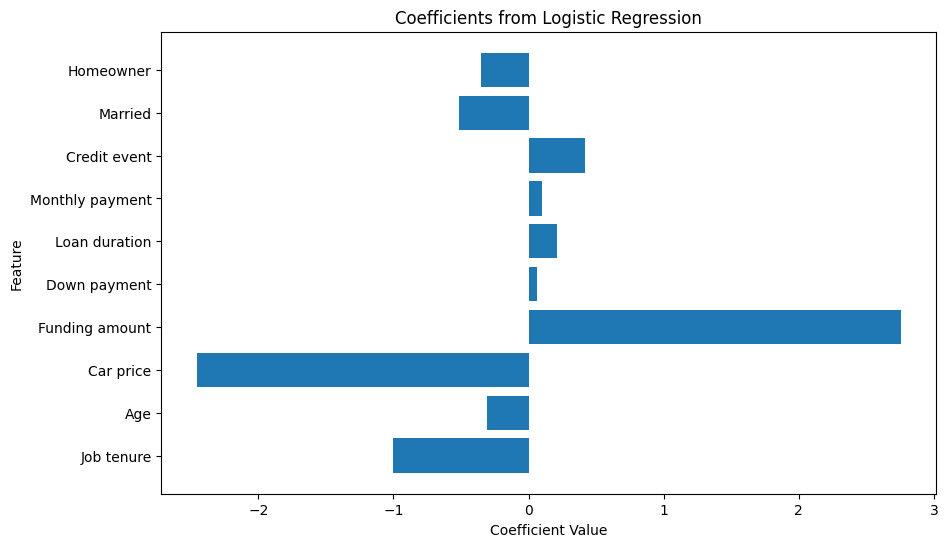

In [60]:
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefs)
plt.title("Coefficients from Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

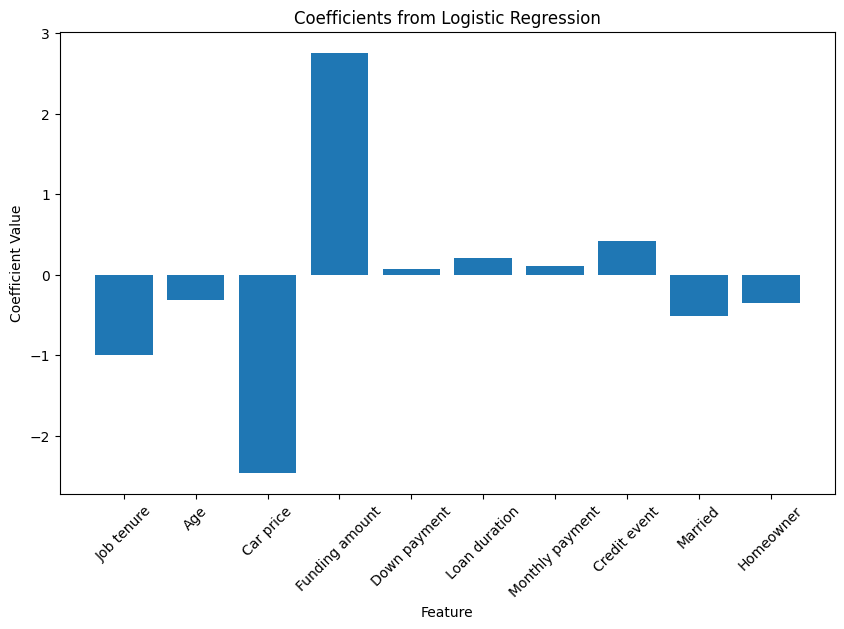

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefs)
plt.title("Coefficients from Logistic Regression")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

- ``Credit event`` has the highest positive coefficient, which means that the presence of a credit event is strongly associated with a higher probability of the predicted outcome.
- ``Married`` has a negative coefficient, meaning being married is associated with a lower probability of the predicted outcome.
- Other variables such as ``Monthly payment``, ``Funding amount``, and ``Job tenure`` have smaller coefficients, indicating they have less influence on the outcome.

# Step 2: Black box models - Random Forest

In [63]:
X = df[
    [
        "Job tenure",
        "Age",
        "Car price",
        "Funding amount",
        "Down payment",
        "Loan duration",
        "Monthly payment",
        "Credit event",
        "Married",
        "Homeowner",
    ]
]


y = df["Default (y)"]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [65]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],  # Number of trees in the forest
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [
        2,
        5,
        10,
    ],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

In [66]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
)


grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=2)

In [67]:
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_

Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [68]:
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

In [71]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [72]:
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8257
AUC-ROC: 0.7825

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      1205
           1       0.68      0.15      0.24       281

    accuracy                           0.83      1486
   macro avg       0.75      0.57      0.57      1486
weighted avg       0.80      0.83      0.78      1486



- Class 0 (Majority Class) has high precision, recall, and F1-score, indicating that the model performs well in identifying this class.
- Class 1 (Minority Class) has lower precision and recall, especially a recall of 0.15, suggesting that the model struggles to correctly identify instances of this class.
- Macro Average Precision (0.75): The precision across both classes is fairly high, especially for the majority class (0.83). However, the precision for the minority class (0.68) pulls the macro average down. This reflects that while the model is better at correctly predicting class 0, it struggles with false positives for class 1.

- Macro Aaverage Recall (0.57): The recall is where the model shows a significant imbalance between the two classes. The recall for class 0 is very high (0.98), but for class 1, it’s only 0.15. This drastic drop lowers the macro average. It indicates that the model often misses instances of class 1 (many false negatives), focusing more on correctly predicting class 0.

- Macro Aaverage F1-score (0.57): The macro average f1-score shows a similar story. Class 0 has a strong balance between precision and recall, but class 1 struggles to achieve a solid f1-score (0.24), which brings the overall macro average down. This reflects that the model does not perform well in balancing precision and recall for the minority class.

In [73]:
feature_importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:\n", importance_df)


Feature Importances:
            Feature  Importance
3   Funding amount    0.183970
0       Job tenure    0.156429
1              Age    0.147802
2        Car price    0.145547
6  Monthly payment    0.140753
5    Loan duration    0.084295
9        Homeowner    0.060695
8          Married    0.042211
7     Credit event    0.030507
4     Down payment    0.007791


In [74]:
result_df = X_test.copy()
result_df["Predicted_PD"] = y_pred_proba
result_df["True_Label"] = y_test.values

print(result_df.head())

result_df.to_csv("predictions_output_random_forest.csv", index=False)

      Job tenure  Age  Car price  Funding amount  Down payment  Loan duration  \
625            2   22       8900            8900             0             60   
2796           0   55      10400            9400             0             72   
101            1   40      15990           14990             0             60   
4767           5   43      19999           23233             0             72   
2018           1   26      11800            4298             1             24   

      Monthly payment  Credit event  Married  Homeowner  Predicted_PD  \
625          0.084828             0        0          0      0.343699   
2796         0.083889             0        0          0      0.296349   
101          0.127142             0        1          0      0.259566   
4767         0.153289             0        0          0      0.354407   
2018         0.115528             0        0          0      0.105127   

      True_Label  
625            1  
2796           0  
101            1 

# Step 2: Black box models - Gradient Boosting Classifier

In [75]:
param_grid_gb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5, 10],
}

In [76]:
gb_model = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid_gb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
)
grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [77]:
print(f"Best parameters for Gradient Boosting: {grid_search_gb.best_params_}")
best_gb_model = grid_search_gb.best_estimator_

Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


In [78]:
y_pred_gb = best_gb_model.predict(X_test)
y_pred_proba_gb = best_gb_model.predict_proba(X_test)[:, 1]
print(f"Optimized Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(
    f"Optimized Gradient Boosting AUC-ROC: {roc_auc_score(y_test, y_pred_proba_gb):.4f}"
)
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

Optimized Gradient Boosting Accuracy: 0.8230
Optimized Gradient Boosting AUC-ROC: 0.7819

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90      1205
           1       0.58      0.24      0.34       281

    accuracy                           0.82      1486
   macro avg       0.71      0.60      0.62      1486
weighted avg       0.79      0.82      0.79      1486



- Class 0 (Majority Class): The model performs very well with class 0, achieving high precision (0.84) and recall (0.96). This shows that the model is extremely good at correctly identifying and minimizing false positives for the majority class.

- Class 1 (Minority Class): There is a notable drop in performance for class 1, where precision is 0.58 and recall is much lower at 0.24. This implies that while the model is able to identify a fair number of true positives (precision), it still struggles significantly in detecting all instances of class 1, with many false negatives slipping through.

- F1-score for class 1 (0.34) further highlights the model’s weakness in handling the minority class, showing a balance between the precision and recall that is below optimal.

- The macro average recall (0.60) and f1-score (0.62) show the imbalance between how the model treats class 0 and class 1. The large disparity in recall indicates that while the model is excellent at identifying class 0, it falters when it comes to class 1.

- The weighted averages are skewed towards class 0 due to its higher support in the data, meaning that the overall performance looks decent (weighted accuracy, precision, and recall near 0.80). However, this masks the poor performance for the minority class.

In [79]:
result_df = X_test.copy()
result_df["Predicted_PD"] = y_pred_proba_gb
result_df["True_Label"] = y_test.values

print(result_df.head())

result_df.to_csv("predictions_output_gradient_boosting.csv", index=False)

      Job tenure  Age  Car price  Funding amount  Down payment  Loan duration  \
625            2   22       8900            8900             0             60   
2796           0   55      10400            9400             0             72   
101            1   40      15990           14990             0             60   
4767           5   43      19999           23233             0             72   
2018           1   26      11800            4298             1             24   

      Monthly payment  Credit event  Married  Homeowner  Predicted_PD  \
625          0.084828             0        0          0      0.290062   
2796         0.083889             0        0          0      0.357017   
101          0.127142             0        1          0      0.225008   
4767         0.153289             0        0          0      0.434658   
2018         0.115528             0        0          0      0.083357   

      True_Label  
625            1  
2796           0  
101            1 

# Step 2: Black box models - XGBoost

In [80]:
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3],
}

In [81]:
xgb_model = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
)

grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [82]:
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
best_xgb_model = grid_search_xgb.best_estimator_

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [83]:
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

print(f"Optimized XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Optimized XGBoost AUC-ROC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

Optimized XGBoost Accuracy: 0.8237
Optimized XGBoost AUC-ROC: 0.7817

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90      1205
           1       0.59      0.23      0.33       281

    accuracy                           0.82      1486
   macro avg       0.71      0.60      0.62      1486
weighted avg       0.79      0.82      0.79      1486



- Class 0 (Majority Class): Precision (0.84) and Recall (0.96) are strong, much like in the other models. XGBoost handles class 0 very well, minimizing false positives and capturing almost all true positives for this class, leading to a high f1-score (0.90).
- Class 1 (Minority Class): Precision (0.59) is moderate, meaning XGBoost makes some correct predictions for class 1 but still struggles with false positives. The recall (0.23) is notably low, indicating the model misses a large proportion of class 1 instances (many false negatives). Consequently, the f1-score (0.33) reflects the challenge XGBoost faces in balancing precision and recall for the minority class.
- The Macro Average Precision (0.71), Recall (0.60), and F1-Score (0.62) are very similar to Gradient Boosting, indicating that XGBoost handles the overall class balance in a comparable manner. The scores show that while XGBoost manages precision well, recall is still the weaker point, especially for the minority class.

In [84]:
result_df = X_test.copy()
result_df["Predicted_PD"] = y_pred_proba_xgb
result_df["True_Label"] = y_test.values

print(result_df.head())

result_df.to_csv("predictions_output_xgboost.csv", index=False)

      Job tenure  Age  Car price  Funding amount  Down payment  Loan duration  \
625            2   22       8900            8900             0             60   
2796           0   55      10400            9400             0             72   
101            1   40      15990           14990             0             60   
4767           5   43      19999           23233             0             72   
2018           1   26      11800            4298             1             24   

      Monthly payment  Credit event  Married  Homeowner  Predicted_PD  \
625          0.084828             0        0          0      0.311191   
2796         0.083889             0        0          0      0.341794   
101          0.127142             0        1          0      0.249162   
4767         0.153289             0        0          0      0.419638   
2018         0.115528             0        0          0      0.067851   

      True_Label  
625            1  
2796           0  
101            1 

# Step 3: Comparison Analysis of Random Forest, Gradient Boosting, and XGBoost:

1. Accuracy:
- Random Forest: 82.57%
- Gradient Boosting: 82.30%
- XGBoost: 82.37%

All three models show nearly identical accuracy, indicating that they are equally effective at making correct predictions for the dataset as a whole. There is no standout model here in terms of overall accuracy. However, accuracy isn't very meaningful with imbalanced data (many more non-default cases).

2. AUC-ROC:
- Random Forest: 0.7825
- Gradient Boosting: 0.7819
- XGBoost: 0.7817

The AUC-ROC scores across all models are very close, with Random Forest slightly outperforming the others, but the difference is too small to be meaningful. All three models perform similarly in distinguishing between the two classes.

3. Class 1 (Minority Class) Performance:

**Precision**:
- Random Forest: 0.68
- Gradient Boosting: 0.58
- XGBoost: 0.59

Random Forest has the highest precision for class 1, meaning it is the best at minimizing false positives for this class. Both Gradient Boosting and XGBoost have lower precision, meaning they predict more false positives for the minority class.

**Recall**:
- Random Forest: 0.15
- Gradient Boosting: 0.24
- XGBoost: 0.23

In terms of recall, both Gradient Boosting and XGBoost significantly outperform Random Forest. They are better at identifying true positives from the minority class, although the improvement is still modest. Random Forest, by contrast, misses the majority of class 1 instances (low recall).

**F1-Score**:
- Random Forest: 0.24
- Gradient Boosting: 0.34
- XGBoost: 0.33

The f1-score, which balances precision and recall, is highest for Gradient Boosting, followed closely by XGBoost. Both models handle the minority class better than Random Forest, though all struggle to achieve a strong balance between precision and recall for class 1.

4. Macro Average Performance:

**Random Forest**:

- Macro Precision: 0.75
- Macro Recall: 0.57
- Macro F1-Score: 0.57

**Gradient Boosting**:

- Macro Precision: 0.71
- Macro Recall: 0.60
- Macro F1-Score: 0.62

**XGBoost**:

- Macro Precision: 0.71
- Macro Recall: 0.60
- Macro F1-Score: 0.62

Both Gradient Boosting and XGBoost have nearly identical macro average performance, slightly outperforming Random Forest in recall and f1-score. This reflects their improved ability to handle both classes, particularly the minority class, compared to Random Forest.

5. Class Imbalance Handling:
- **Random Forest** favors the majority class heavily, resulting in a high recall for class 0 but poor recall for class 1. This model minimizes false positives for class 1 but misses most instances of the minority class (very low recall).

- **Gradient Boosting** shows better balance by improving recall for class 1, though at the cost of slightly lower precision. It shows a reasonable balance between class 0 and class 1 but still struggles to fully address class imbalance.

- Similar to Gradient Boosting, **XGBoost** improves recall for class 1 while maintaining comparable precision. It performs almost identically to Gradient Boosting, showing better detection of minority class instances while sacrificing some precision.

**Conclusion and Forecasting Analysis**:

Random Forest performs best in terms of precision for class 1, minimizing false positives, but has the weakest recall, leading to the lowest f1-score for class 1.

Gradient Boosting offers a better balance with improved recall for class 1 and a higher f1-score compared to Random Forest. It has a low precision but does a better job overall at capturing minority class instances. 

XGBoost performs nearly identically to Gradient Boosting. It also balances precision and recall for class 1 better than Random Forest, with slightly better recall than Random Forest but at the same precision level as Gradient Boosting.

In summary, for better minority class detection, both Gradient Boosting and XGBoost are superior to Random Forest. However, Gradient Boosting and XGBoost are preferable since class imbalance needs to be addressed with a more balanced precision-recall tradeoff.

### Exporting the best model

In [85]:
model = best_gb_model
joblib.dump(model, "gradient_boosting_model.pkl")

['gradient_boosting_model.pkl']

# Step 7: SHAP method

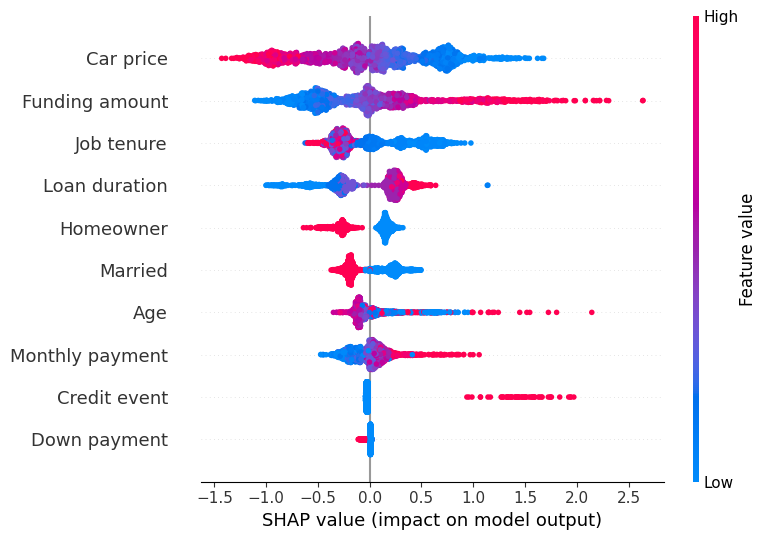

In [ ]:
import shap

# Initialize SHAP Tree Explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)

<Figure size 640x480 with 0 Axes>

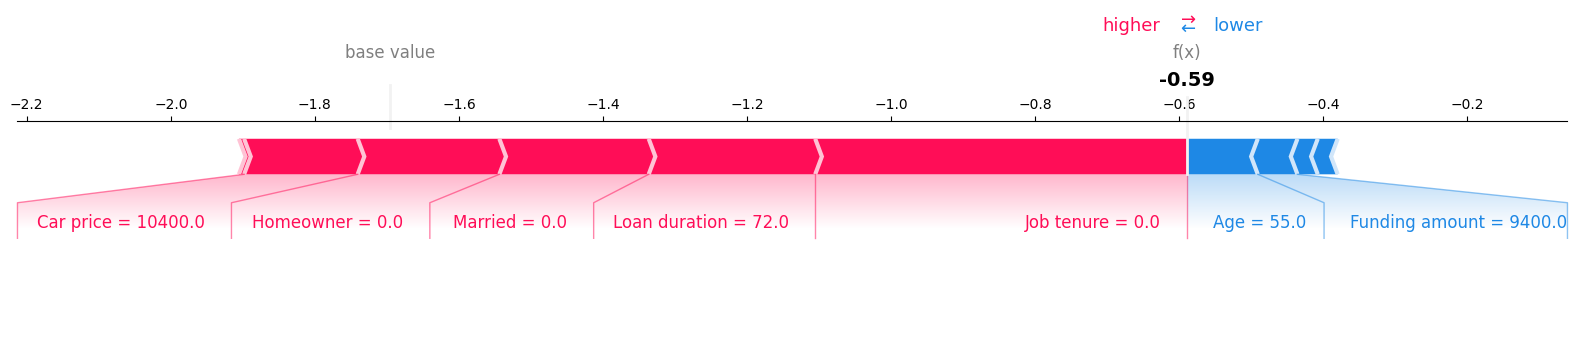

In [ ]:
import matplotlib.pyplot as plt

# Initialize the JavaScript visualization library
# shap.initjs()

# Force plot for a single prediction (e.g., first instance in the test set)
# shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# Create a figure and save it using matplotlib's savefig function
plt.figure()
shap.force_plot(
    explainer.expected_value, shap_values[1], X_test.iloc[1], matplotlib=True
)

<Figure size 640x480 with 0 Axes>

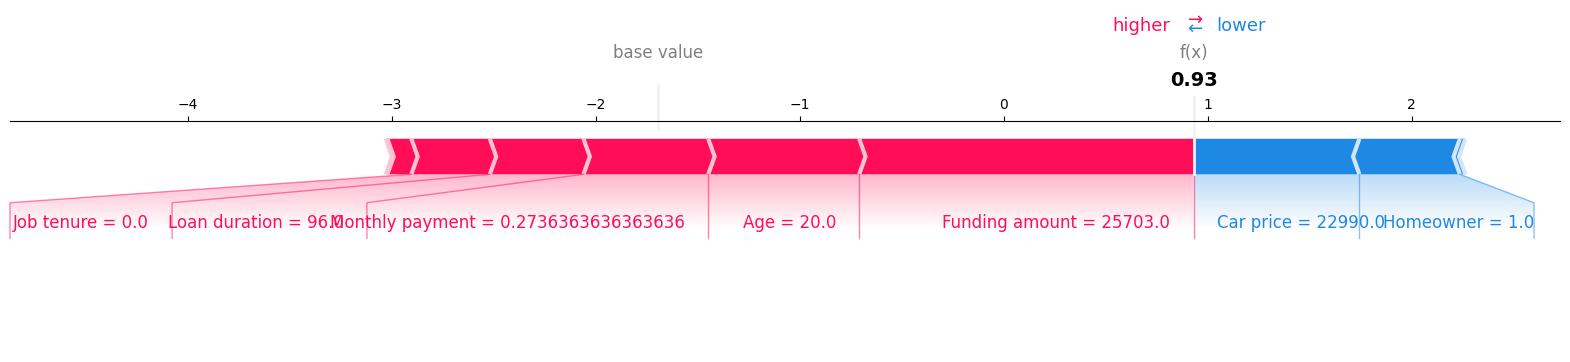

In [ ]:
# Create a figure and save it using matplotlib's savefig function
plt.figure()
shap.force_plot(
    explainer.expected_value, shap_values[9], X_test.iloc[9], matplotlib=True
)

<Figure size 640x480 with 0 Axes>

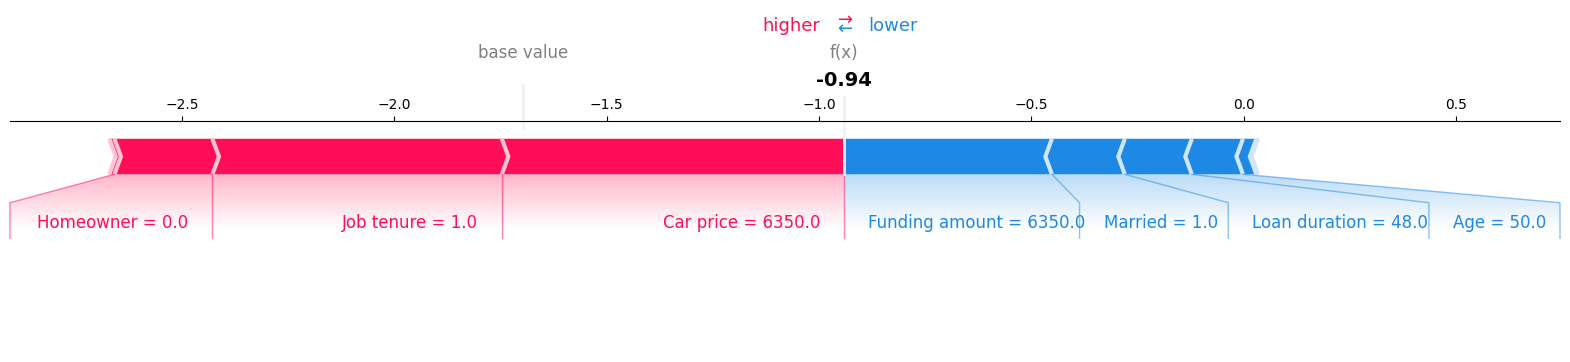

In [ ]:
# Create a figure and save it using matplotlib's savefig function
plt.figure()
shap.force_plot(
    explainer.expected_value, shap_values[15], X_test.iloc[15], matplotlib=True
)

# Step 8: Performance Interpretability

## 1. XPER

We are going to end up with an AUC of 0.76/0.80 do not try to improve it much more (for the black box model).

Sample 500 random values from X_test and get the corresponding y_test values:

In [ ]:
# Generate a list of random indices
random_indices = np.random.choice(len(X_test), size=500, replace=False)

# Select the corresponding samples from X_test and y_test
X_test_sampled = X_test.iloc[random_indices]
y_test_sampled = y_test.iloc[random_indices]

In [ ]:
import XPER
from XPER.compute.Performance import ModelPerformance

# Define the evaluation metric(s) to be used
XPER = ModelPerformance(
    X_train.values, y_train.values, X_test_sampled.values, y_test_sampled.values, model
)

# Evaluate the model performance using the specified metric(s)
PM_auc = XPER.evaluate(["AUC"])
PM_ba = XPER.evaluate(["Balanced_accuracy"])

# Print the performance metrics
print("Performance Metrics: ")
print("AUC: ", round(PM_auc, 3))
print("Balanced accuracy: ", round(PM_ba, 3))

Performance Metrics: 
AUC:  0.783
Balanced accuracy:  0.616


In [ ]:
# Calculate XPER values for the model's performance
XPER_values = XPER.calculate_XPER_values(
    ["Balanced_accuracy"], kernel=True, N_coalition_sampled=10
)  # takes 48 min

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

10


Performing Computation: 100%|██████████| 1/1 [00:37<00:00, 37.25s/it]


In [ ]:
np.savez("data/XPER_values_ba.npz", array1=XPER_values[0], array2=XPER_values[1])

In [ ]:
from XPER.viz.Visualisation import visualizationClass as viz

labels = list(X.columns)

In [ ]:
viz.bar_plot(
    XPER_values=XPER_values, X_test=X_test, labels=labels, p=10, percentage=True
)

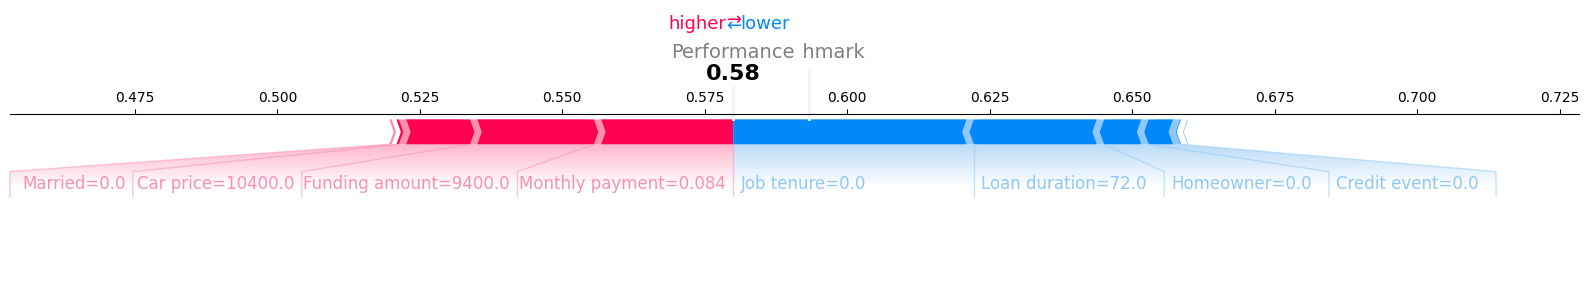

In [ ]:
viz.force_plot(
    XPER_values=XPER_values,
    instance=1,
    X_test=X_test,
    variable_name=labels,
    figsize=(16, 4),
)

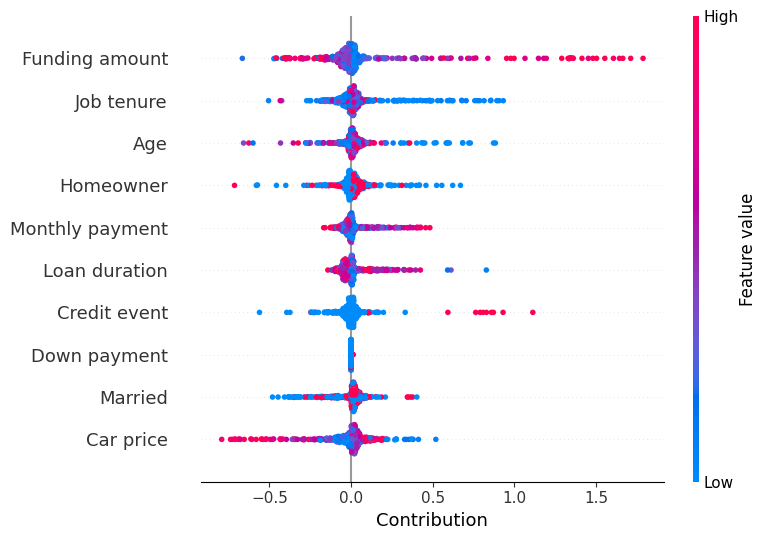

In [ ]:
# Will only work once we
viz.beeswarn_plot(XPER_values=XPER_values, X_test=X_test_sampled, labels=labels)

## 2. Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    model, X, y, n_repeats=30, random_state=0, scoring="balanced_accuracy"
)

Only features with a significant contribution (where the mean importance minus two standard deviations is positive) are printed.

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(
            f"{X.columns[i]}: "
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}"
        )

Funding amount: 0.046 +/- 0.005
Job tenure: 0.042 +/- 0.003
Monthly payment: 0.032 +/- 0.002
Age: 0.022 +/- 0.002
Homeowner: 0.019 +/- 0.002
Credit event: 0.014 +/- 0.002
Loan duration: 0.011 +/- 0.003


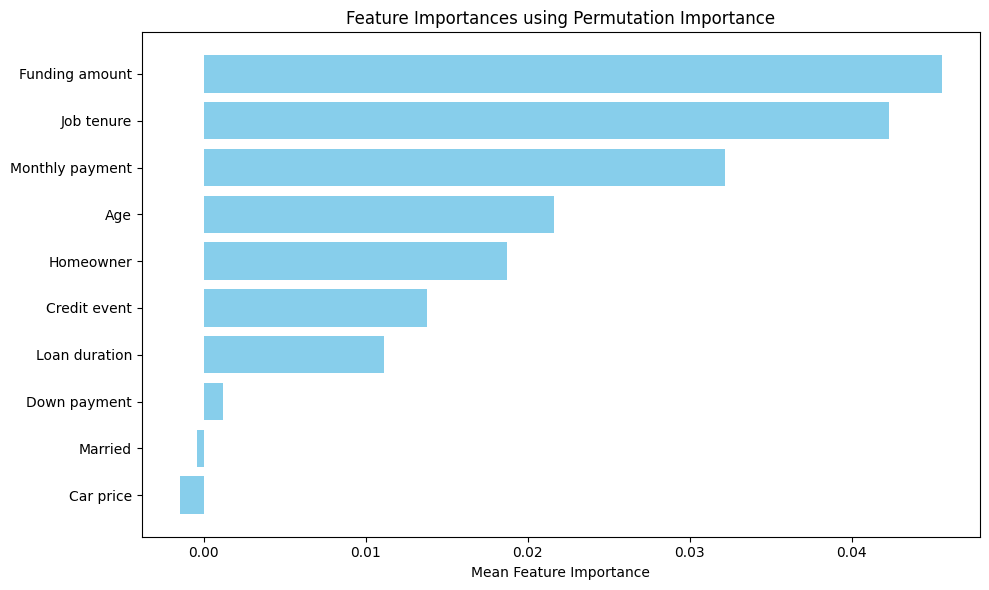

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume X_val.columns contains the feature names, and r.importances_mean contains the importances
# Sorting features by importance
sorted_idx = np.argsort(r.importances_mean)

# Plotting horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], r.importances_mean[sorted_idx], color="skyblue")

# Adding labels and title
plt.xlabel("Mean Feature Importance")
plt.title("Feature Importances using Permutation Importance")
plt.show()